### ***Vasilii Mosin***

In [17]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from IPython.display import Audio
from StringIO import StringIO

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!wget https://www.dropbox.com/s/jtdc7y0bi00ii4p/genres.tar.gz?dl=0 -O genres.tar.gz 
!tar -xzf genres.tar.gz 

In [18]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}'></audio>".format(url))

In [19]:
sound_file = './genres/blues/blues.00000.au'

y, sr = librosa.load(sound_file)
librosa.output.write_wav('./genres/tmp.wav', y, sr, norm=True)
Audio(url='./genres/tmp.wav')

# Sound as 1D-Signal

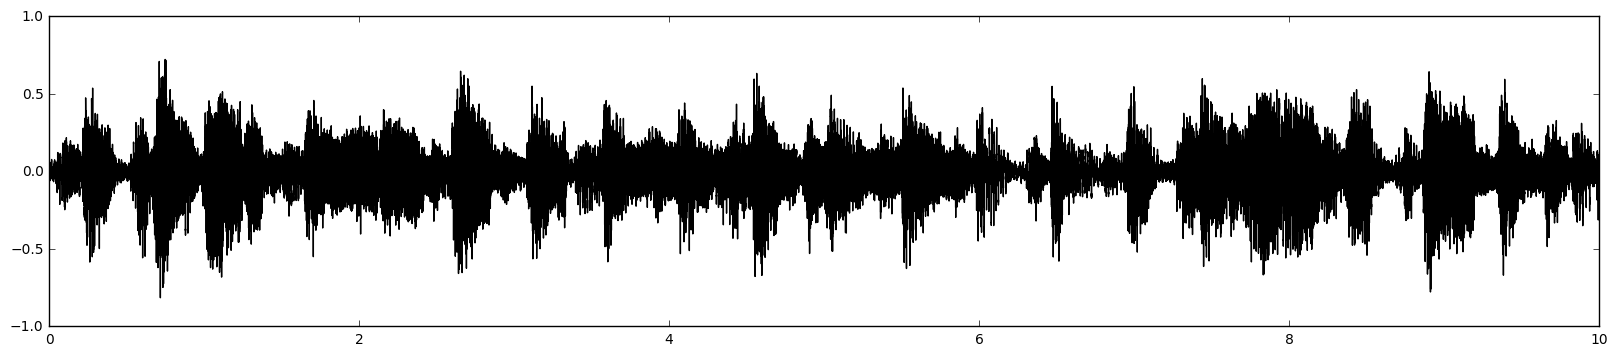

In [20]:
plt.figure(figsize=(20,4))
pylab.plot(np.arange(len(y)) * 1.0 /sr, y, 'k')
pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

In [21]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

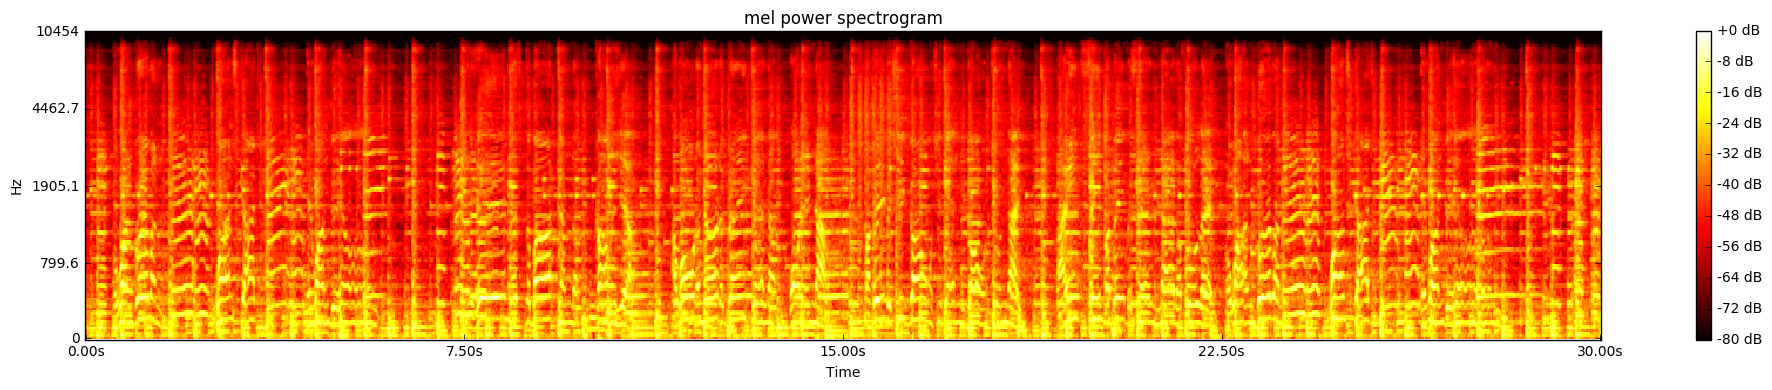

In [22]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [23]:
def get_spectgorgamm(fname):
    y, sr = librosa.load(fname)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.logamplitude(S, ref_power=np.max)
    return log_S[:, :1200]

def plot_spectrogramm(log_S):
    plt.figure(figsize=(20,4))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
    plt.title('mel power spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

# Prepare a data

In [24]:
geners = ['blues', 'country', 'hiphop', 'metal', 'reggae', 'classical', 'disco', 'jazz', 'pop', 'rock']

id2gener = dict()
X_names, y = [], []
for gener_id, gener in enumerate(geners):
    id2gener[gener_id] = gener
    for track in os.listdir('./genres/' + gener):
        if '.mp3' in track or '.au' in track and '_' not in track:
            trackfile = os.path.join('./genres/', gener, track)
            X_names.append(trackfile)
            y.append(gener_id)

In [27]:
from multiprocessing import Pool

ncpu = 4
X = Pool(ncpu).map(get_spectgorgamm, X_names)

# Nearest Neighbors genre classification

In [35]:
perm = np.random.permutation(len(y))
X, X_names, y = np.array(X)[perm].astype('float32'), np.array(X_names)[perm], np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:800], Xreshape[800:]
y_train, y_valid = y[:800], y[800:]

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_jobs=ncpu)

clf = clf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)
y_val_pred = clf.predict(X_valid.reshape((X_valid.shape[0], -1)))

print accuracy_score(y_valid, y_val_pred)

0.41


# Convolution Nural Nets

![](http://benanne.github.io/images/spotify_convnet.png)

http://benanne.github.io/2014/08/05/spotify-cnns.html

In [41]:
import theano
import lasagne
import theano.tensor as T

In [42]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X_train, X_valid = Xreshape[:800], Xreshape[800:]
y_train, y_valid = y[:800], y[800:]

input_X, target_y = T.tensor3("X", dtype='float64'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X) 

nn = lasagne.layers.Conv1DLayer(nn, 32, 4)
nn = lasagne.layers.MaxPool1DLayer(nn, 2)

nn = lasagne.layers.Conv1DLayer(nn, 32, 3)
nn = lasagne.layers.MaxPool1DLayer(nn, 2)

nn = lasagne.layers.Conv1DLayer(nn, 32, 3)
nn = lasagne.layers.MaxPool1DLayer(nn, 2)

nn = lasagne.layers.Conv1DLayer(nn, 64, 3)
nn = lasagne.layers.GlobalPoolLayer(nn)

nn = lasagne.layers.DenseLayer(nn, num_units=300)
nn = lasagne.layers.DropoutLayer(nn, 0.3)
nn = lasagne.layers.DenseLayer(nn, num_units=300)
nn = lasagne.layers.DenseLayer(nn, 10, nonlinearity=lasagne.nonlinearities.softmax)

In [43]:
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [44]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [ ]:
%%time 

conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=100, batch_size=50)

Epoch   1 of 100 train_loss = 1.71 val_loss = 1.74 train_acc = 35.38 val_acc = 38.00


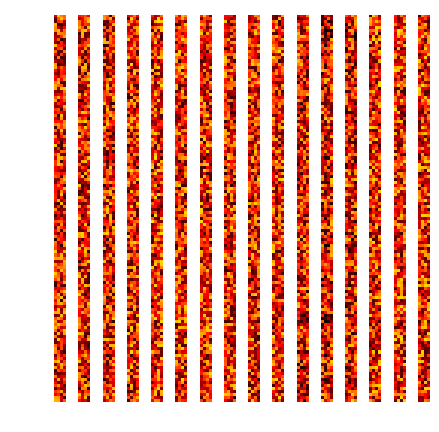

In [46]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Find Simular Tracks

<img src="./img/cnn_gr.png" width="500">

In [47]:
from sklearn.neighbors import NearestNeighbors

In [48]:
represent = lasagne.layers.get_output(nn.input_layer.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [49]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

In [50]:
nn_pred = NearestNeighbors(metric='cosine', algorithm='brute')

In [51]:
nn_pred = nn_pred.fit(track_vectors)

In [52]:
X_names[0]

'./genres/hiphop/hiphop.00072.au'

In [53]:
ans = list(X_names[nn_pred.kneighbors(track_vectors[0])[1][0]])
ans

['./genres/hiphop/hiphop.00072.au',
 './genres/reggae/reggae.00048.au',
 './genres/blues/blues.00002.au',
 './genres/disco/disco.00090.au',
 './genres/classical/classical.00042.au']

In [54]:
sound_file = ans[0]
y, sr = librosa.load(sound_file)
librosa.output.write_wav('./genres/tmp.wav', y, sr, norm=True)
Audio(url='./genres/tmp.wav')

In [55]:
sound_file = ans[1]
y, sr = librosa.load(sound_file)
librosa.output.write_wav('./genres/tmp.wav', y, sr, norm=True)
Audio(url='./genres/tmp.wav')

# Maps of tracks by svd and tsne

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [56]:
from sklearn.manifold import TSNE

In [57]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [58]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)
track_labels = np.array(list(y_train) + list(y_valid))

In [59]:
X_tsne = TSNE(n_components=2).fit_transform(track_vectors)

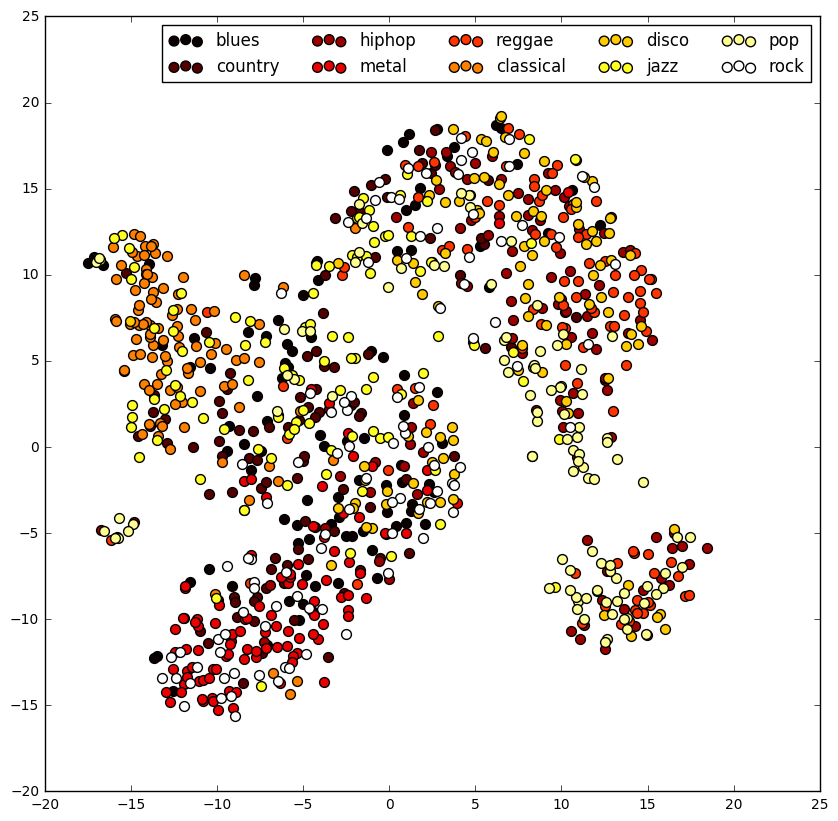

In [60]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(X_tsne[:, 0][idx_], X_tsne[:, 1][idx_], c=colors[idx], cmap=cm.hot, label=gener,s=50)

pylab.legend(loc=0, ncol=5)